## _*Quantum SVM algorithm:  multiclass classifier extension*_

A multiclass extension works in conjunction with an underlying binary (two classes) classifier to provide multiclass classification.
Here we choose the `Wine` dataset which has 3 classes.

In [45]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler

from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_algorithms.state_fidelities import ComputeUncompute

In [46]:
# function to get sklearn wine dataset, take the desired number of samples and features, scale it and plot it

def wine(training_size, test_size, n_features, plot_data=False):
    """ returns wine dataset """
    data, target = load_wine(return_X_y=True)
    sample_train, sample_test, label_train, label_test = train_test_split(data, target, test_size=test_size, random_state=42)

    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)

    pca = PCA(n_components=n_features).fit(sample_train)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)

    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler(feature_range=(-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)

    sample_train = sample_train[:training_size, :]
    label_train = label_train[:training_size]
    sample_test = sample_test[:training_size, :]
    label_test = label_test[:training_size]

    if plot_data:
        try:
            import matplotlib.pyplot as plt
        except ImportError:
            raise NameError('Matplotlib not installed. Please install it before plotting')
        for k in range(0, 3):
            plt.scatter(sample_train[label_train == k, 0][:training_size],
                        sample_train[label_train == k, 1][:training_size])

        plt.title("PCA dim. reduced Wine dataset")
        plt.show()

    return sample_train, label_train, sample_test, label_test

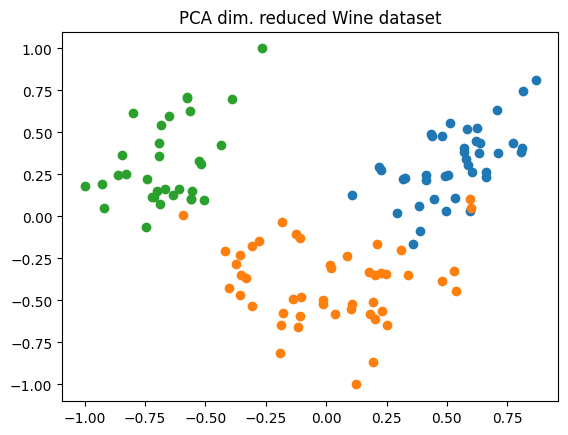

In [53]:
train_data, train_labels, test_data, test_labels = wine(
    training_size=120,
    test_size=20, n_features=2, plot_data=True
)

In [55]:
feature_map = ZZFeatureMap(2)

fidelity = ComputeUncompute(sampler=Sampler())
new_kernel = FidelityQuantumKernel(feature_map=feature_map, fidelity=fidelity)

# you can use One-Versus-One classification ('ovo') or One-Versus-Rest ('ovr')
qsvc = QSVC(quantum_kernel=new_kernel, decision_function_shape='ovr')

qsvc.fit(train_data, train_labels)
print(f'Training set accuracy {qsvc.score(train_data, train_labels)}; test set accuracy: {qsvc.score(test_data, test_labels)}')

Training set accuracy 0.8916666666666667; test set accuracy: 0.8


In [56]:
! pip freeze | grep qiskit

qiskit==1.1.0
qiskit-aer==0.14.2
qiskit-algorithms==0.3.0
qiskit-ibm-runtime==0.25.0
qiskit-machine-learning==0.7.2
qiskit-nature==0.7.2
qiskit-nature-pyscf==0.4.0
qiskit-qasm3-import==0.5.0
qiskit-transpiler-service==0.4.5
